In [23]:
# 🔁 Step 1: Load All CSV Files 
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")

# 🔧 Step 2: Clean Oil Data

In [24]:
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

# 🔗 Step 3: Merge Datasets

In [25]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [26]:
train = pd.merge(train, stores, on='store_nbr', how='left')
test = pd.merge(test, stores, on='store_nbr', how='left')

In [27]:
train = pd.merge(train, oil, on='date', how='left')
test = pd.merge(test, oil, on='date', how='left')

In [28]:
# Prepare holiday flags by date
holidays["is_holiday"] = 1
holiday_flags = holidays.groupby("date")["is_holiday"].max().reset_index()

train = pd.merge(train, holiday_flags, on='date', how='left')
test = pd.merge(test, holiday_flags, on='date', how='left')

train['is_holiday'].fillna(0, inplace=True)
test['is_holiday'].fillna(0, inplace=True)

# 🛠️ Step 4: Feature Engineering

In [29]:
# 2. Feature Engineering
for df in [train, test]:
    df["day"] = df["date"].dt.day
    df["week"] = df["date"].dt.isocalendar().week
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["dayofweek"] = df["date"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

In [30]:
for df in [train, test]:
    df["is_payday"] = ((df["day"] == 15) | (df["day"] == df["date"].dt.days_in_month)).astype(int)

In [31]:
earthquake_date = pd.to_datetime("2016-04-16")
train["earthquake"] = (train["date"] == earthquake_date).astype(int)
test["earthquake"] = (test["date"] == earthquake_date).astype(int)

# 📊 Rolling Statistics & Lag Features

In [32]:
train.sort_values(by=["store_nbr", "family", "date"], inplace=True)

train["sales_lag_7"] = train.groupby(["store_nbr", "family"])["sales"].shift(7)
train["sales_ma_7"] = train.groupby(["store_nbr", "family"])["sales"].transform(lambda x: x.shift(1).rolling(7).mean())
train["sales_std_7"] = train.groupby(["store_nbr", "family"])["sales"].transform(lambda x: x.shift(1).rolling(7).std())

# 🏬 Store-Specific Aggregates

In [33]:
# Avg sales per store type
store_avg_sales = train.groupby("type")["sales"].mean().reset_index().rename(columns={"sales": "avg_sales_store_type"})
train = train.merge(store_avg_sales, on="type", how="left")
test = test.merge(store_avg_sales, on="type", how="left")

# Top-selling product families per cluster
top_families = train.groupby(["cluster", "family"])["sales"].mean().reset_index()
top_families = top_families.sort_values(["cluster", "sales"], ascending=[True, False])
top_families = top_families.groupby("cluster").head(3)  # Top 3 per cluster
top_families["top_family_flag"] = 1

train = train.merge(top_families[["cluster", "family", "top_family_flag"]], on=["cluster", "family"], how="left")
test = test.merge(top_families[["cluster", "family", "top_family_flag"]], on=["cluster", "family"], how="left")

train["top_family_flag"].fillna(0, inplace=True)
test["top_family_flag"].fillna(0, inplace=True)

# Exploratory Data Analysis (EDA)

E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


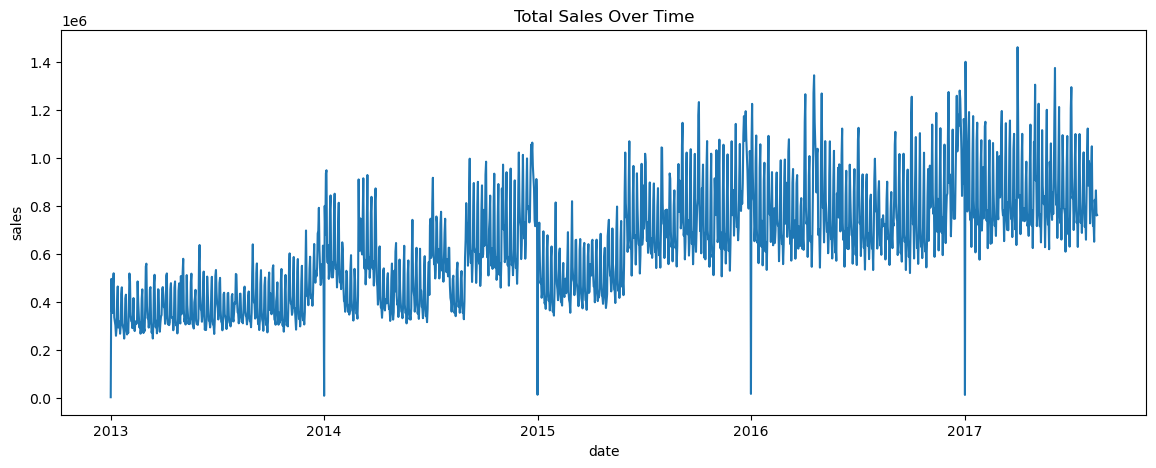

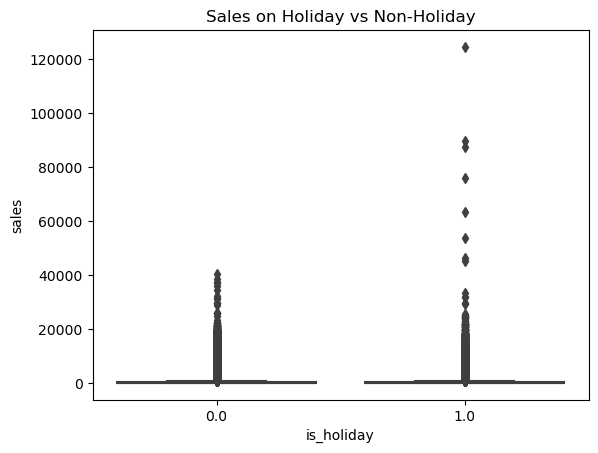

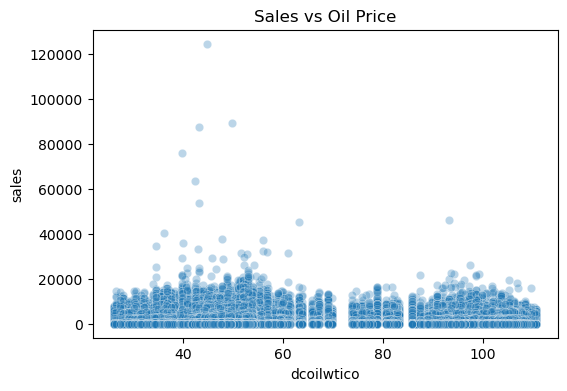

E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


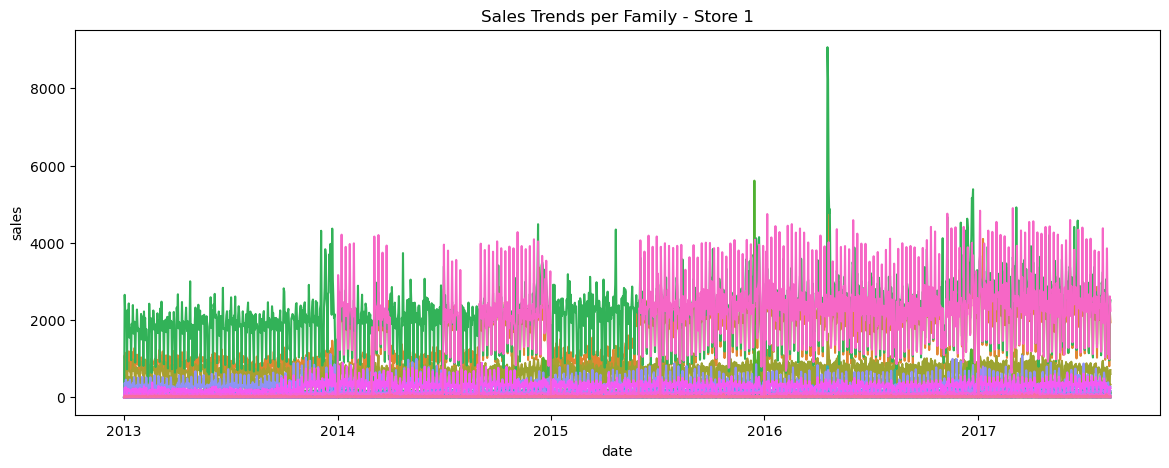

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sales Trend Over Time
train_grouped = train.groupby("date")["sales"].sum().reset_index()
plt.figure(figsize=(14, 5))
sns.lineplot(data=train_grouped, x="date", y="sales")
plt.title("Total Sales Over Time")
plt.show()

# Sales Before and After Holidays
sns.boxplot(x="is_holiday", y="sales", data=train)
plt.title("Sales on Holiday vs Non-Holiday")
plt.show()

# Correlation between oil and sales
plt.figure(figsize=(6, 4))
sns.scatterplot(data=train, x="dcoilwtico", y="sales", alpha=0.3)
plt.title("Sales vs Oil Price")
plt.show()

# Check for anomalies (e.g., spikes/dips)
plt.figure(figsize=(14, 5))
sns.lineplot(data=train[train['store_nbr']==1], x="date", y="sales", hue="family", legend=False)
plt.title("Sales Trends per Family - Store 1")
plt.show()

In [35]:
# Sort by store, family, and date
df_all = pd.concat([train, test])
df_all = df_all.sort_values(['store_nbr', 'family', 'date'])

# Lag Features
df_all['sales_lag_7'] = df_all.groupby(['store_nbr', 'family'])['sales'].shift(7)

# Rolling Mean and Std (past 7 days)
df_all['sales_ma_7'] = df_all.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df_all['sales_std_7'] = df_all.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).std())

# Separate again into train/test
train = df_all[df_all['sales'].notnull()]
test = df_all[df_all['sales'].isnull()]

In [36]:
# Features 
features = [
    'onpromotion', 'sales_lag_7', 'sales_ma_7', 'sales_std_7',
    'day', 'week', 'month', 'year', 'dayofweek', 'is_weekend',
    'is_holiday', 'is_payday'
]

target = 'sales'

# Drop NA rows (initial rows with no lag/rolling data)
train = train.dropna(subset=features + [target])

# 🔹 Baseline (Naïve) Model

In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Naive prediction using lag
y_true = train[target]
y_pred = train['sales_lag_7']

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print("🔹 Baseline (Naïve) Model")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

🔹 Baseline (Naïve) Model
RMSE: 394.30
R²: 0.8722
MAPE: 8645835488382187.0000


# 🌲 Random Forest 

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Prepare train and test data
X_train = train[features]
y_train = train[target]
X_test = test[features]

# Train model with reduced complexity
rf_model = RandomForestRegressor(
    n_estimators=30,       # Reduced from 100 to 30
    max_depth=10,          # Limit tree depth to save memory
    min_samples_leaf=10,   # Control leaf size
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predict on training data
train['rf_pred'] = rf_model.predict(X_train)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_train, train['rf_pred']))
r2 = r2_score(y_train, train['rf_pred'])
mape = mean_absolute_percentage_error(y_train, train['rf_pred'])

print("🌲 Random Forest (Reduced Estimators)")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

🌲 Random Forest (Reduced Estimators)
RMSE: 260.45
R²: 0.9443
MAPE: 6495338115680055.0000


# 📈 ARIMA Model

E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


📈 ARIMA Model
RMSE: 75.97
R²: 0.5317
MAPE: 4045691899524393.5000


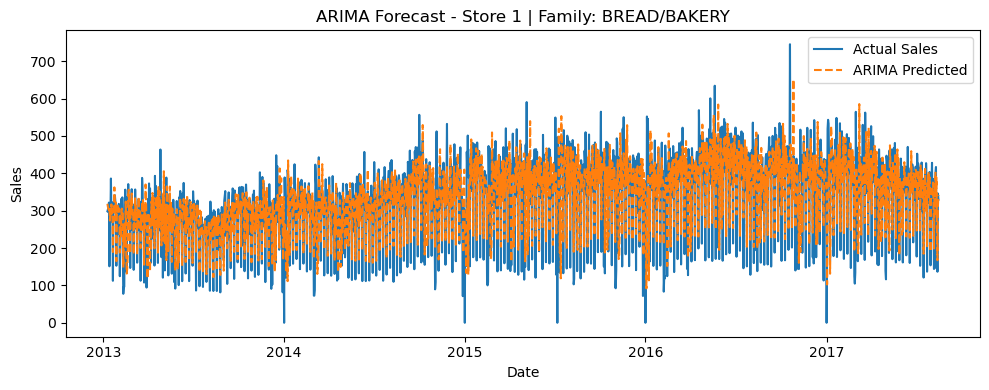

In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Filter for one store and family (you can loop later for more)
store = 1
family = 'BREAD/BAKERY'

df_arima = train[(train['store_nbr'] == store) & (train['family'] == family)].copy()
df_arima = df_arima.sort_values('date')

# Set date as index
df_arima.set_index('date', inplace=True)

# Fit ARIMA model
model = ARIMA(df_arima['sales'], order=(7,1,1))  # You can tune this
model_fit = model.fit()

# Predict on training data
df_arima['arima_pred'] = model_fit.predict(start=1, end=len(df_arima)-1, typ='levels')

# Evaluate
actual = df_arima['sales'].iloc[1:]  # first value dropped due to ARIMA diff
predicted = df_arima['arima_pred'].iloc[1:]

rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)

print("📈 ARIMA Model")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_arima.index[1:], actual, label='Actual Sales')
plt.plot(df_arima.index[1:], predicted, label='ARIMA Predicted', linestyle='--')
plt.legend()
plt.title(f"ARIMA Forecast - Store {store} | Family: {family}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

In [40]:
import numpy as np

def safe_mape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    mask = actual != 0  # Avoid divide-by-zero
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask]))

# ⚡ XGBoost Model

In [41]:
from xgboost import XGBRegressor

# Prepare train/test data
X_train = train[features]
y_train = train[target]
X_test = test[features]

# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=50,       # Reduce if memory is low
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict on training set
train['xgb_pred'] = xgb_model.predict(X_train)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_train, train['xgb_pred']))
r2 = r2_score(y_train, train['xgb_pred'])
mape = safe_mape(y_train, train['xgb_pred'])

print("⚡ XGBoost Model")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

⚡ XGBoost Model
RMSE: 255.10
R²: 0.9465
MAPE: 0.7773


In [21]:
!pip uninstall tensorflow
!pip install tensorflow-cpu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Filter for 1 store + 1 family to reduce memory
df_lstm = train[(train['store_nbr'] == 1) & (train['family'] == 'GROCERY I')].copy()

# Sort by date
df_lstm = df_lstm.sort_values('date')

# Normalize sales
scaler = MinMaxScaler()
df_lstm['sales_scaled'] = scaler.fit_transform(df_lstm[['sales']])

# Create sequences
def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 14
X, y = create_sequences(df_lstm['sales_scaled'].values, window_size)

# Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build model
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=16, verbose=1)

# Predict on train
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)

print("🧠 LSTM Model")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM - Actual vs Predicted Sales")
plt.legend()
plt.show()

# 🔮 Prophet Model

In [43]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 1.3 MB/s eta 0:00:11
   ---------------------------------------- 0.1/13.3 MB 1.2 MB/s eta 0:00:12
   ---------------------------------------- 0.1/13.3 MB 1.0 MB/s eta 0:00:13
   ---------------------------------------- 0.2/13.3 MB 1.1 MB/s eta 0:00:13
    --------------------------------------- 0.2/13.3 MB 958.4 kB/s eta 0:00:14
    --------------------------------------- 0.2/13.3 MB 942.1 kB/s eta 0:00:14
    --------------------------------------- 0.3/13.3 MB 930.9 kB/s eta 0:00:15
    --------------------------------------- 0.3/13.3 MB 922.8 kB/s eta 0:00:15
   - -------------------------------------- 0.4/13.3 MB 928.4 kB/s eta 0:00:14
   - -------------------------------------- 0.4/13.3 MB 913.9 kB/s eta 0:00:15
   - -------------------------------------- 0.4/13.3 MB 888.6 kB/s eta 0:00:15
   - -------------------------------------- 0.5/13.3 MB 906.4 kB/s et

07:25:38 - cmdstanpy - INFO - Chain [1] start processing
07:25:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\2756875209.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future = model.make_future_dataframe(periods=len(test[test['store_nbr'] == store][test['family'] == family]), freq='D')


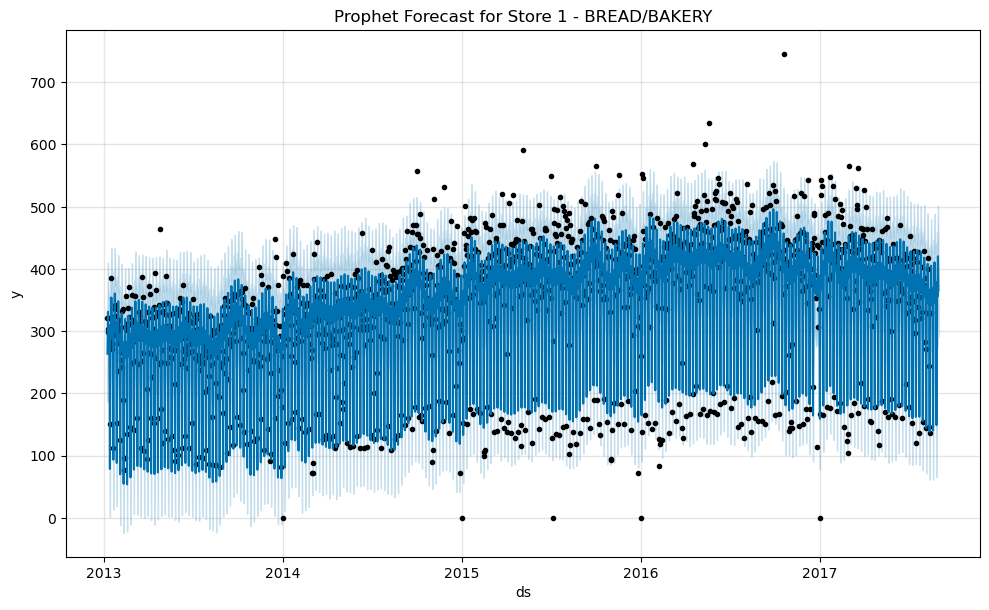

🔮 Prophet Model
RMSE: 60.49
R²: 0.7029
MAPE: 4249731386733505.0000


In [44]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 🔍 Filter for 1 store + 1 family to keep it simple
store = 1
family = 'BREAD/BAKERY'
df_prophet = train[(train['store_nbr'] == store) & (train['family'] == family)][['date', 'sales']].copy()

# 📅 Prophet needs columns named 'ds' and 'y'
df_prophet.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# 🧙‍♂️ Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)

# 📆 Make future dataframe (based on test set length)
future = model.make_future_dataframe(periods=len(test[test['store_nbr'] == store][test['family'] == family]), freq='D')

# 🔮 Predict future
forecast = model.predict(future)

# 📈 Plot forecast
model.plot(forecast)
plt.title(f"Prophet Forecast for Store {store} - {family}")
plt.show()

# 📊 Evaluation (on train only)
y_true = df_prophet['y']
y_pred = forecast.loc[:len(y_true)-1, 'yhat']

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print("🔮 Prophet Model")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

# 📊 Model Performance Comparison 

In [47]:
import pandas as pd

# Model results
results = {
    'Model': [
        'Baseline (Naïve)',
        'Random Forest',
        'ARIMA',
        'XGBoost',
        'Prophet'
    ],
    'RMSE': [
        394.30,   # baseline
        260.45,   # rf
        75.97,    # arima
        255.10,   # xgb
        60.49     # prophet
    ],
    'R²': [
        0.8722,
        0.9443,
        0.5317,
        0.9465,
        0.7029
    ],
    'MAPE': [
        8645835488382187.0,
        6495338115680055.0,
        4045691899524393.5,
        0.7773,
        4249731386733505.0
    ]
}

# Create DataFrame
df_results = pd.DataFrame(results)

# Format MAPE for readability
df_results['MAPE'] = df_results['MAPE'].apply(lambda x: f"{x:.4f}" if x < 1000 else f"{x:.2e}")

# Highlight model with:
# - Minimum RMSE
# - Maximum R²
min_rmse_idx = df_results['RMSE'].idxmin()
max_r2_idx = df_results['R²'].idxmax()

def highlight_row(row):
    if row.name == min_rmse_idx or row.name == max_r2_idx:
        return ['background-color: #d4edda'] * len(row)  # light green
    else:
        return [''] * len(row)

# Display with highlight
styled_df = df_results.style.apply(highlight_row, axis=1).set_caption("📊 Model Performance Comparison (Best highlighted)")
styled_df

,Model,RMSE,R²,MAPE
0,Baseline (Naïve),394.300000,0.872200,8.65e+15
1,Random Forest,260.450000,0.944300,6.50e+15
2,ARIMA,75.970000,0.531700,4.05e+15
3,XGBoost,255.100000,0.946500,0.7773
4,Prophet,60.490000,0.702900,4.25e+15


# 📉 Sales Forecasting - ARIMA Model

C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\1309238089.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()


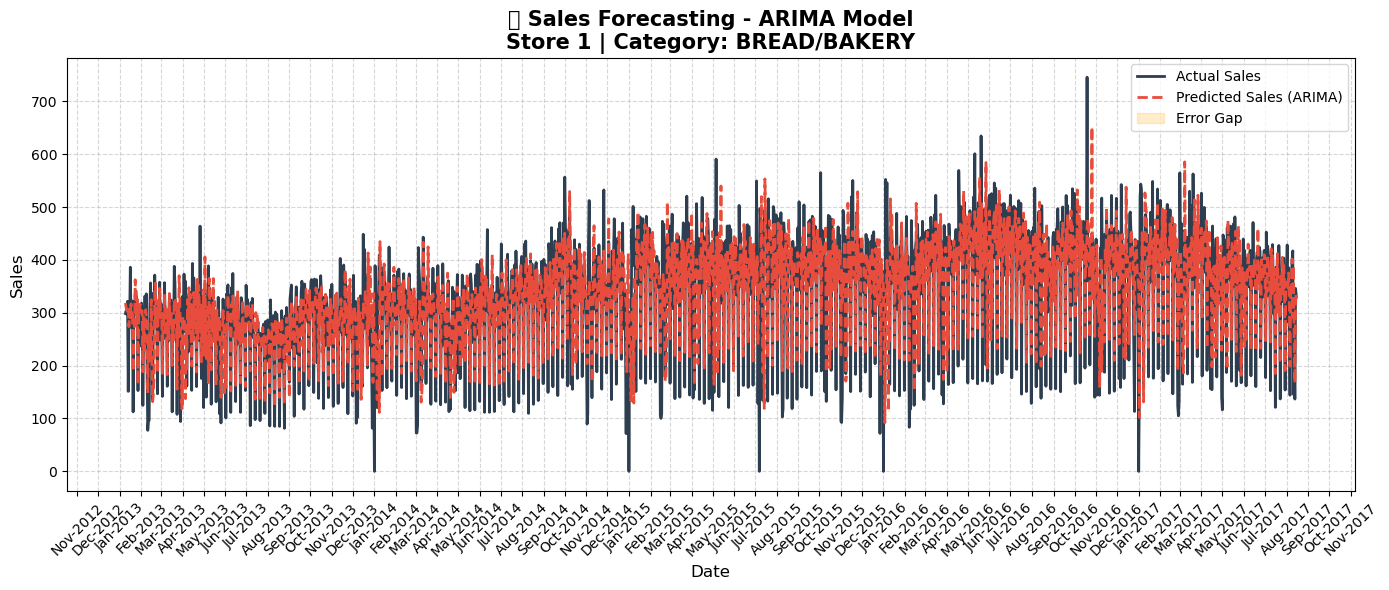

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))

# Plot actual and predicted lines
plt.plot(df_arima.index[1:], actual, label='Actual Sales', color='#2C3E50', linewidth=2)
plt.plot(df_arima.index[1:], predicted, label='Predicted Sales (ARIMA)', linestyle='--', color='#E74C3C', linewidth=2)

# Fill the gap between actual and predicted to show deviation
plt.fill_between(df_arima.index[1:], actual, predicted, color='orange', alpha=0.2, label='Error Gap')

# Style the plot
plt.title("📉 Sales Forecasting - ARIMA Model\nStore 1 | Category: BREAD/BAKERY", fontsize=15, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Improve x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 📈 R² Score Comparison Across Models

C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\1070133597.py:9: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
E:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


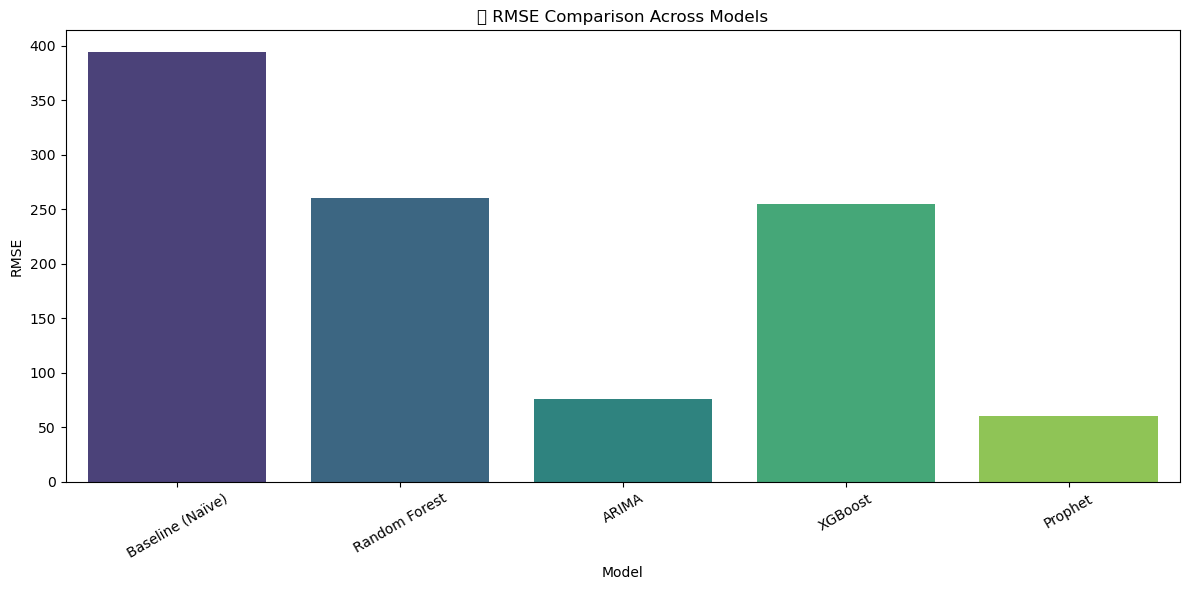

C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\1070133597.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
E:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


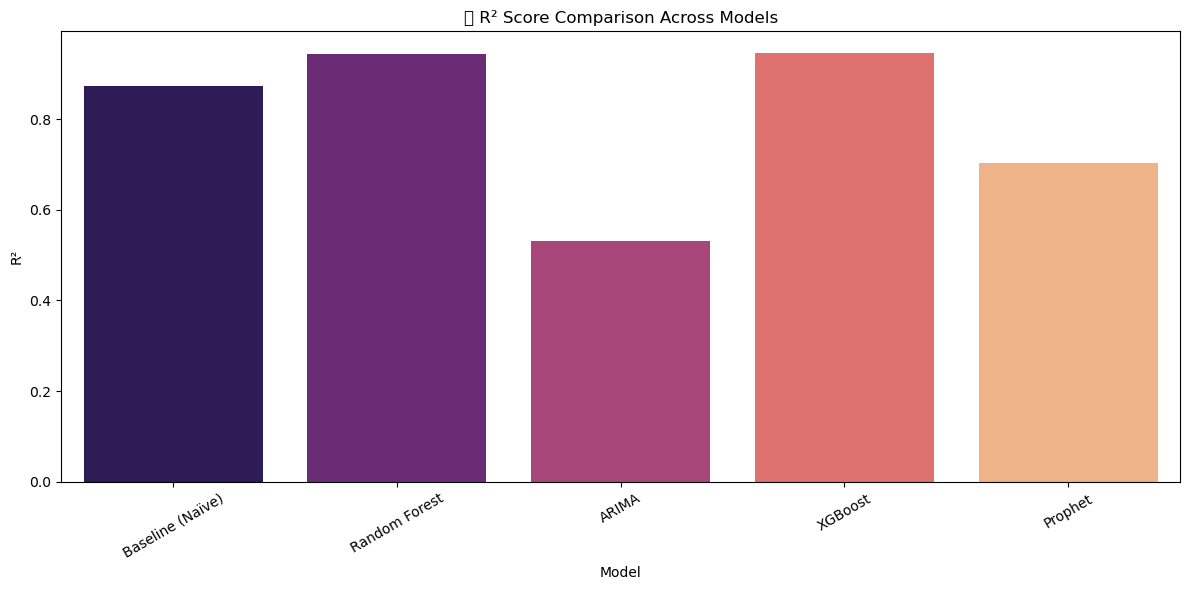

In [50]:
import seaborn as sns

# Use df_results from tabulation code
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='Model', y='RMSE', palette='viridis')
plt.title("🔍 RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='Model', y='R²', palette='magma')
plt.title("📈 R² Score Comparison Across Models")
plt.ylabel("R²")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 🌲 Top 10 Important Features - Random Forest

C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\1080238552.py:14: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from current font.
  plt.tight_layout()
E:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


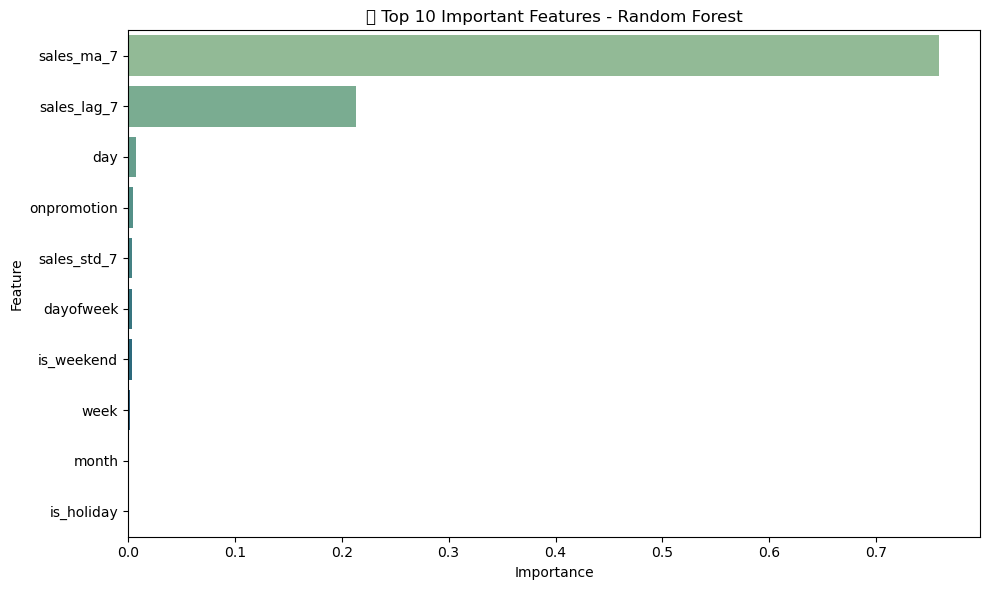

In [51]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
rf_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
rf_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_imp_df.head(10), x='Importance', y='Feature', palette='crest')
plt.title("🌲 Top 10 Important Features - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ⚡ Top 10 Important Features - XGBoost

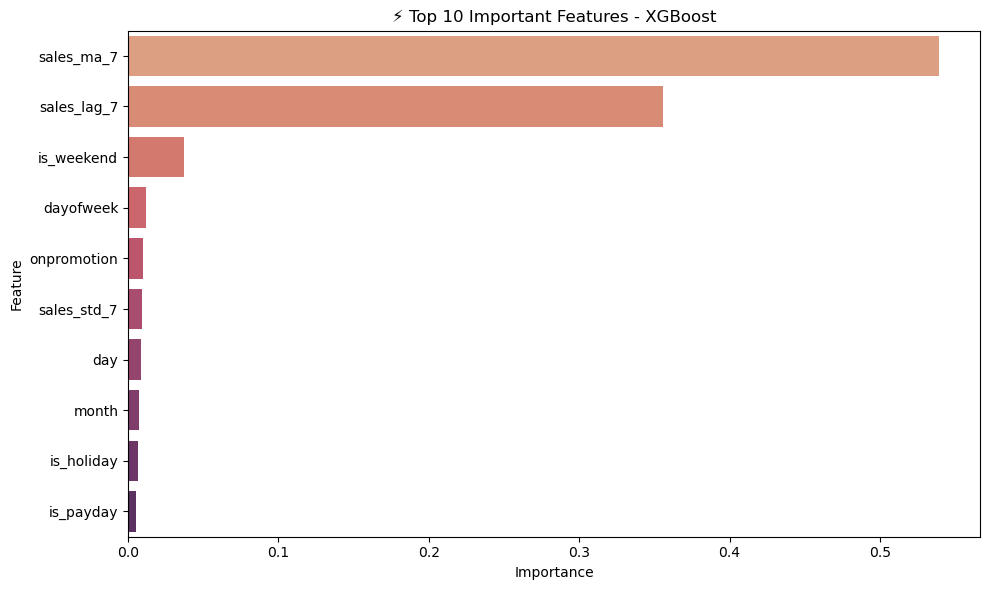

In [52]:
xgb_importance = xgb_model.feature_importances_

xgb_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
})
xgb_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_imp_df.head(10), x='Importance', y='Feature', palette='flare')
plt.title("⚡ Top 10 Important Features - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 📊 Actual vs Predicted Sales

C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\2056687074.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


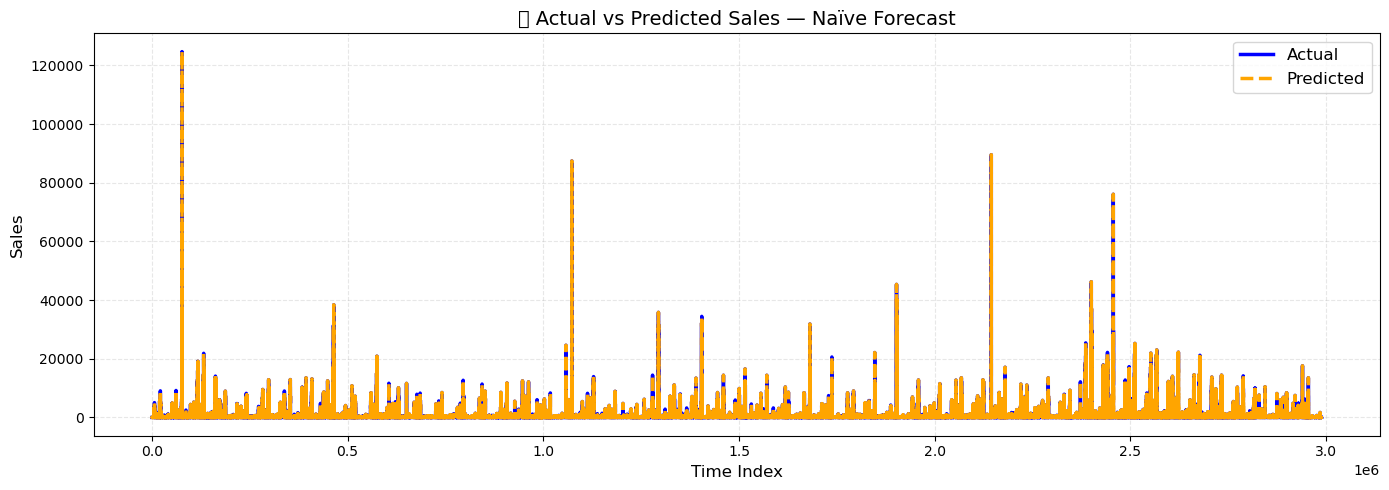

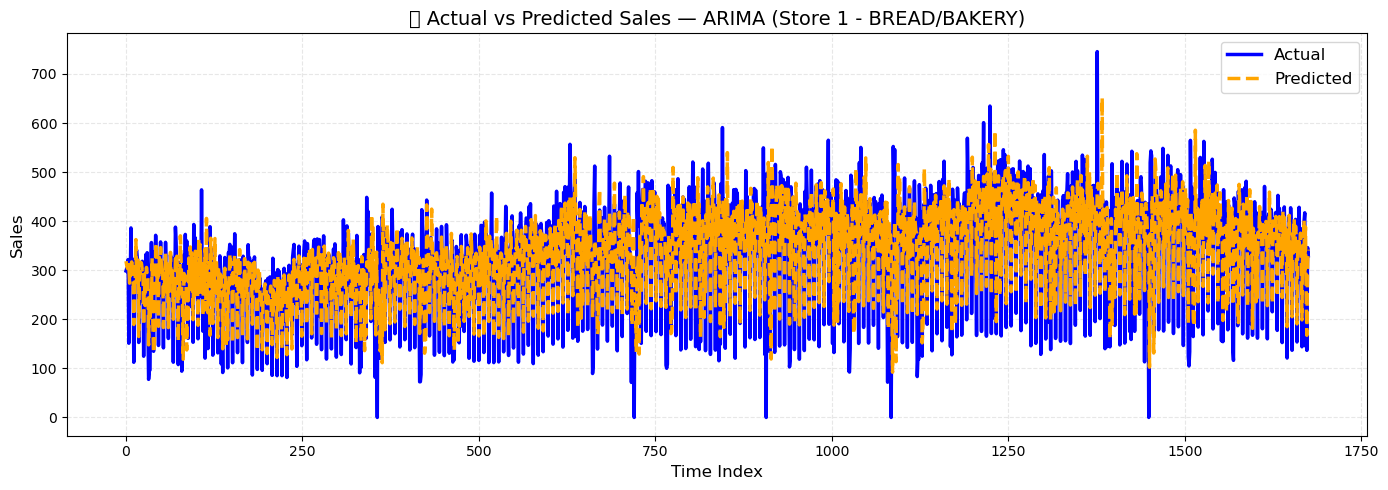

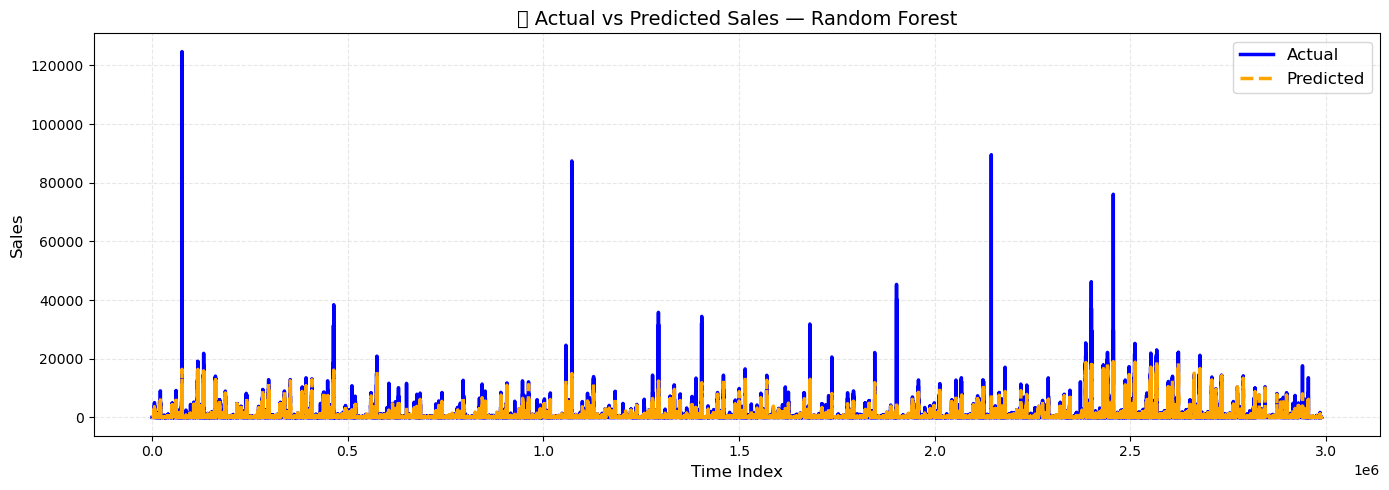

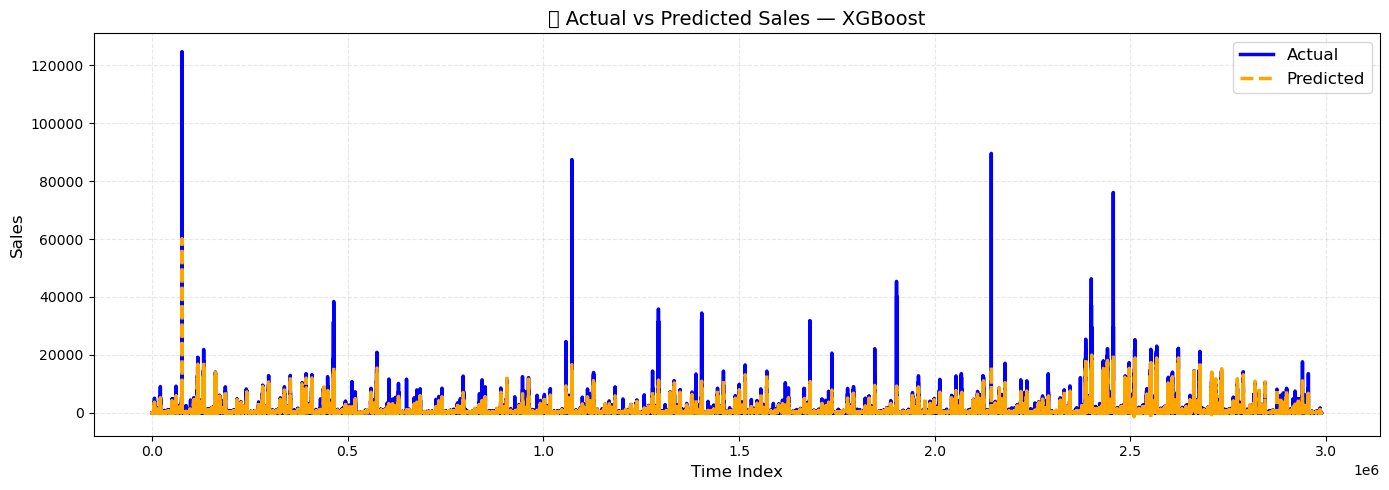

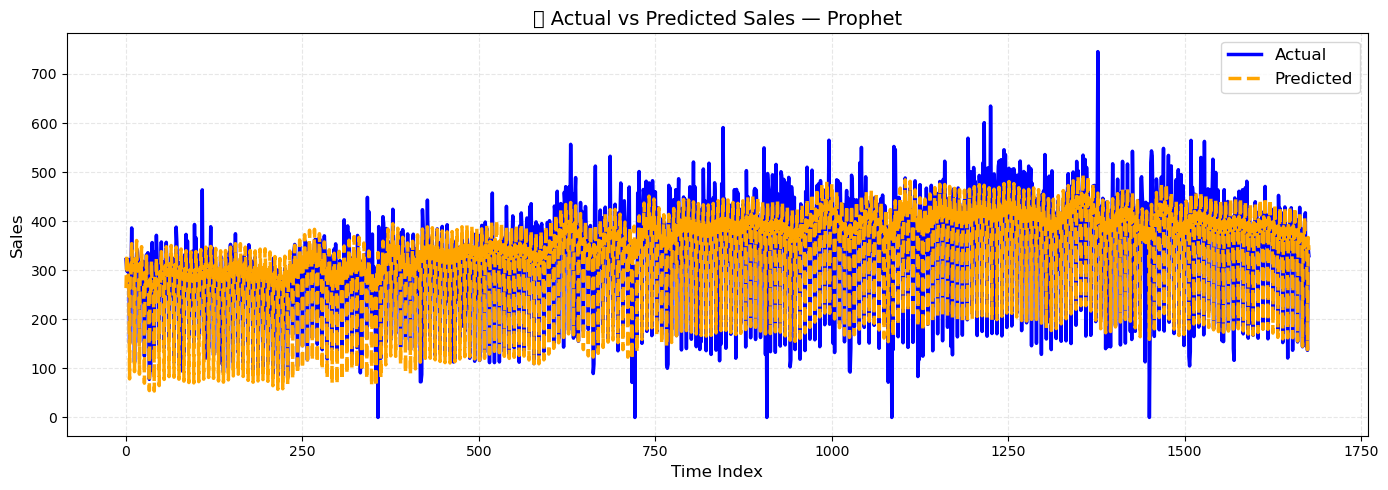

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Better Helper Function for Clearer Line Plot
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(14, 5))

    plt.plot(y_true.reset_index(drop=True), label='Actual', color='blue', linewidth=2.5)
    plt.plot(y_pred.reset_index(drop=True), label='Predicted', linestyle='--', color='orange', linewidth=2.5)

    plt.title(f'📊 Actual vs Predicted Sales — {model_name}', fontsize=14)
    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plots for Each Model

# 1. Naïve Forecast (Lag-based)
plot_actual_vs_predicted(train[target], train['sales_lag_7'], 'Naïve Forecast')

# 2. ARIMA
plot_actual_vs_predicted(actual, predicted, 'ARIMA (Store 1 - BREAD/BAKERY)')

# 3. Random Forest
plot_actual_vs_predicted(train[target], train['rf_pred'], 'Random Forest')

# 4. XGBoost
plot_actual_vs_predicted(train[target], train['xgb_pred'], 'XGBoost')

# 5. Prophet
plot_actual_vs_predicted(df_prophet['y'], forecast.loc[:len(df_prophet)-1, 'yhat'], 'Prophet')

In [55]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train model on training data
xgb_model.fit(train[features], train[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [56]:
# Predict on test set
test['sales'] = xgb_model.predict(X_test)

# Clip negative values (sales can't be negative)
test['sales'] = test['sales'].clip(0)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\1453587511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sales'] = xgb_model.predict(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7144\1453587511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sales'] = test['sales'].clip(0)


In [60]:
# Create submission dataframe
submission = test[['id', 'sales']]

# Save to CSV
submission.to_csv('submission_saravanan__P.csv', index=False)

# Show sample
print("✅ Submission file created!")
print(submission.head())

✅ Submission file created!
           id         sales
0     3000888      6.314178
1782  3002670   7814.918457
3564  3004452   7719.728516
5346  3006234   9730.918945
7128  3008016  11301.556641
